In [30]:
import asyncio
import aiohttp
import json
import sqlite3
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String
import urllib
from pandas.io import sql
from datetime import datetime
import numpy as np
import requests
from time import perf_counter
import matplotlib.pyplot as plt

# Performance Testing

In [2]:
class ConfigReader:
    def get_value(self, key):
        with open('config.json') as json_data_file:
            data = json.load(json_data_file)
        return data[key]

In [3]:
class DbManager:
    def __init__(self):
        reader = ConfigReader()
        db_connection = reader.get_value("db_connection")        
        self.conn_string = '{db_engine}{connector}://{user}:{password}@{server}/{database}'.format(
            db_engine=db_connection['db_engine'],
            connector=db_connection['connector'],
            user=db_connection['user'],
            password=db_connection['password'],
            server=db_connection['server'],
            database=db_connection['database'])

    def get_users(self):
        return sql.read_sql("SELECT distinct userId FROM ratings;", create_engine(self.conn_string))

## Get random users

In [11]:
n_rand_users = 100
dbManager = DbManager()
db_users = dbManager.get_users()
n_rand_users = db_users.sample(n=n_rand_users)

## Test recommendation endpoint

In [41]:
base_url = 'http://127.0.0.1:8000'
algo_rec = 'popular'
algo_pred = 'itemitem' # 'biasedmf'
n_recs = 5
items = "10,20,30,40,50"
pred_algos = ['bias','itemitem','useruser','biasedmf','implicitmf','funksvd','bpr']
rec_algos = ['popular']
num_workers = 4
warm_up_user = 1

### Parallel performance

In [42]:
def print_stats(time_taken_all, num_requests):
    print(f'Total response time: {time_taken_all}')
    print(f'Throughput (requests per second): {num_requests / time_taken_all}')
    
async def get_recs():
    tasks = []    
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_recs = perf_counter()

    async with aiohttp.ClientSession() as session:
        for idx, row in n_rand_users.iterrows():
            task = asyncio.ensure_future(get_user_recs(row['userId'], n_recs, algo_rec, session))
            tasks.append(task)     

        responses = await asyncio.gather(*tasks)
        time_taken_all = perf_counter() - start_recs
        print_stats(time_taken_all, num_requests)

async def get_preds():
    tasks = []    
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_preds = perf_counter()

    async with aiohttp.ClientSession() as session:
        for idx, row in n_rand_users.iterrows():
            task = asyncio.ensure_future(get_user_preds(row['userId'], algo_pred, items, session))
            tasks.append(task)         

        responses = await asyncio.gather(*tasks)
        time_taken_all = perf_counter() - start_preds
        print_stats(time_taken_all, num_requests)

async def get_user_preds(userId, algo, items, session):
    url = f'{base_url}/algorithms/{algo}/predictions?user_id={userId}&items={items}'
    async with session.get(url) as resp:
        data = await resp.json()        
        
async def get_user_recs(userId, nr_recs, algo, session):
    url = f'{base_url}/algorithms/{algo}/recommendations?user_id={userId}&num_recs={nr_recs}'
    async with session.get(url) as resp:
        data = await resp.json()
        #data = resp.json()

### Single thread performance

In [43]:
def print_stats_single_thread(times, time_taken_all, num_requests):
    print(f'Total response time: {time_taken_all}')
    print(f'Throughput (requests per second): {num_requests / time_taken_all}')
    print(f'Peak response time: {max(times)}')
    print(f'Mean response time: {np.mean(times)}')
    print(f'99 percentile: {np.quantile(times, 0.99)}')
    
def get_recs_single_thread():
    times = []
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_recs = perf_counter()
    for idx, row in n_rand_users.iterrows():
        start = perf_counter()
        get_user_recs_single_thread(row['userId'], n_recs, algo_rec)
        time_taken = perf_counter() - start
        times.append(time_taken)
#        print(f'Response time: {time_taken}')
    time_taken_all = perf_counter() - start_recs
    print_stats_single_thread(times, time_taken_all, num_requests)
    return times

def get_preds_single_thread():
    times = []
    start_preds = perf_counter()
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')    
    for idx, row in n_rand_users.iterrows():
        start = perf_counter()
        get_user_preds_single_thread(row['userId'], algo_pred, items)
        time_taken = perf_counter() - start
        times.append(time_taken)
#        print(f'Response time: {time_taken}')
    time_taken_all = perf_counter() - start_preds
    print_stats_single_thread(times, time_taken_all, num_requests)
    return times
    
def get_user_preds_single_thread(userId, algo, items):
    url = f'{base_url}/algorithms/{algo}/predictions?user_id={userId}&items={items}'
    r = requests.get(url)
    data = r.json()
    
def get_user_recs_single_thread(userId, nr_recs, algo):
    url = f'{base_url}/algorithms/{algo}/recommendations?user_id={userId}&num_recs={nr_recs}'
    r = requests.get(url)
    data = r.json()    

### Warm up phase

In [44]:
for algo in pred_algos:
    for w in range(num_workers):
        async with aiohttp.ClientSession() as session:
            get_user_preds_single_thread(warm_up_user, algo, items)

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /algorithms/bias/predictions?user_id=1&items=10,20,30,40,50 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x11886fbd0>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [28]:
print('-------------------------------------')
print('Predictions results')
loop = asyncio.get_event_loop()
# future = asyncio.ensure_future(get_preds())
# loop.run_until_complete(future)
await loop.create_task(get_preds())

print('-------------------------------------')
print('Predictions results in single thread')
preds_times = get_preds_single_thread()

-------------------------------------
Predictions results
Number of requests: 100
Total response time: 0.14142066499971406
Throughput (requests per second): 707.110237391418
-------------------------------------
Predictions results in single thread
Number of requests: 100
Total response time: 0.5530236540007536
Throughput (requests per second): 180.82409183868967
Peak response time: 0.007137908999538922
Mean response time: 0.005312818540014632
99 percentile: 0.006480480689670006


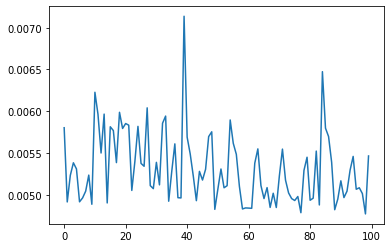

In [31]:
plt.plot(preds_times)
plt.show()

In [9]:
# print('-------------------------------------')
# print('Recomendation results')
# loop = asyncio.get_event_loop()
# loop.run_until_complete(get_recs())
# loop.close()

# print('-------------------------------------')
# print('Recommendations results in single thread')
# get_recs_single_thread()